# Project 2 - Trisha Flores
E-News Express Project
Due 8/27/2021


1) Explore the dataset and extract insights using Exploratory Data Analysis.

2) Do the users spend more time on the new landing page than the old landing page?

3) Is the conversion rate (the proportion of users who visit the landing page and get converted) for the new page greater than the conversion rate for the old page?

4) Does the converted status depend on the preferred language? [Hint: Create a contingency table using the pandas.crosstab() function]

5) Is the mean time spent on the new page same for the different language users?

*Consider a significance level of 0.05 for all tests.



# Data Dictionary:

* user_id - This represents the user ID of the person visiting the website.
* group - This represents whether the user belongs to the first group (control) or the second group (treatment).
* landing_page - This represents whether the landing page is new or old.
* time_spent_on_the_page - This represents the time (in minutes) spent by the user on the landing page.
* converted - This represents whether the user gets converted to a subscriber of the news portal or not.
* language_preferred - This represents the language chosen by the user to view the landing page.

In [1]:
# import the important packages
import pandas as pd  # library used for data manipulation and analysis
import numpy as np  # library used for working with arrays
import matplotlib.pyplot as plt  # library for visualization
import seaborn as sns  # library for visualization
%matplotlib inline

# this library contains a large number of probability distributions 
# as well as a growing library of statistical functions
import scipy.stats as stats  

#imported to see skewness
from scipy.stats import skew,norm,probplot,boxcox,f_oneway

#imported to change figure size
from matplotlib import rcParams

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Read in dataset
df = pd.read_csv('abtest.csv')

#Copy dataset to different dataframe for quality protection
news=df.copy()

In [3]:
#Check the shape
news.shape

(100, 6)

In [4]:
#Check the first 5 rows
news.head()

,user_id,group,landing_page,time_spent_on_the_page,converted,language_preferred
0,546592,control,old,3.48,no,Spanish
1,546468,treatment,new,7.13,yes,English
2,546462,treatment,new,4.40,no,Spanish
3,546567,control,old,3.02,no,French
4,546459,treatment,new,4.75,yes,Spanish


In [5]:
#Get the info of the data
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   user_id                 100 non-null    int64  
 1   group                   100 non-null    object 
 2   landing_page            100 non-null    object 
 3   time_spent_on_the_page  100 non-null    float64
 4   converted               100 non-null    object 
 5   language_preferred      100 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 4.8+ KB


Looks like 100 values as expected, none missing
4 objects which need to be converted to categories, also userid, so 5

In [6]:
#Convert the object types to category types
news["user_id"]=news["user_id"].astype("category")
news["group"]=news["group"].astype("category")
news["landing_page"]=news["landing_page"].astype("category")
news["converted"]=news["converted"].astype("category")
news["language_preferred"]=news["language_preferred"].astype("category")

In [7]:
#Check info again to verify the type changes
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   user_id                 100 non-null    category
 1   group                   100 non-null    category
 2   landing_page            100 non-null    category
 3   time_spent_on_the_page  100 non-null    float64 
 4   converted               100 non-null    category
 5   language_preferred      100 non-null    category
dtypes: category(5), float64(1)
memory usage: 6.7 KB


# Get a statistical summary of the data

In [8]:
#Stat summary 
news.describe()

,time_spent_on_the_page
count,100.000000
mean,5.377800
std,2.378166
min,0.190000
25%,3.880000
50%,5.415000
75%,7.022500
max,10.710000


* Mean is 5.38 for time spent on page
* Std is 2.38, so not a large spread to the times
* Min is 0.19 and Max is 10.71, so again, not a large spread to time on page

In [9]:
#Categorical data too
news.describe(include=["category"])

,user_id,group,landing_page,converted,language_preferred
count,100,100,100,100,100
unique,100,2,2,2,3
top,546443,control,new,yes,French
freq,1,50,50,54,34


* 2 unique types for group, landing page, and converted
* 3 unique types for language, French top
* group and landing page have 50 for the top freq, so an even distribution (which is expected)

In [10]:
#Check for missing values
news.isnull().sum()

user_id                   0
group                     0
landing_page              0
time_spent_on_the_page    0
converted                 0
language_preferred        0
dtype: int64

* No missing values

In [11]:
#select_dtypes()- returns a subset of the dataframe based on the data types that are provided in the 'include' parameter.
#Getting a printo of just the numerical column names for the skew lambda function
num_sel=news.select_dtypes(include=["float64"])
num_sel.columns

Index(['time_spent_on_the_page'], dtype='object')

In [12]:
#Check for skewness
skewed_ = num_sel.apply(lambda x : skew(x.dropna())).sort_values(ascending=False)
skewed_

time_spent_on_the_page   -0.147229
dtype: float64

* Time spent not really skewed, a very slight left or negative tendency

# EDA

In [13]:
#FROM CLASS IPYNB** Cardio_Good_Fitness
# While doing uni-variate analysis of numerical variables we want to study their central tendency 
# and dispersion.
# Let us write a function that will help us create boxplot and histogram for any input numerical 
# variable.
# This function takes the numerical column as the input and returns the boxplots 
# and histograms for the variable.
# Let us see if this help us write faster and cleaner code.
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

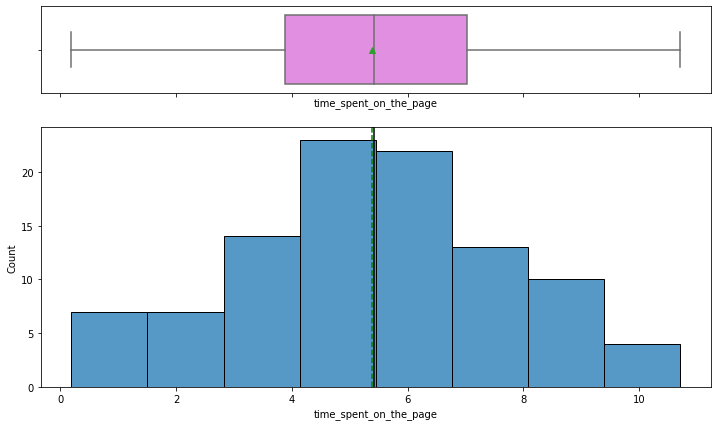

In [14]:
histogram_boxplot(news, "time_spent_on_the_page")
plt.savefig('histogram.jpg',bbox_inches='tight')
plt.show()

* Looks like a normal distribution
* Median and mean are together

In [20]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.savefig('barplot_language.jpg')
    #plt.show()  # show the plot

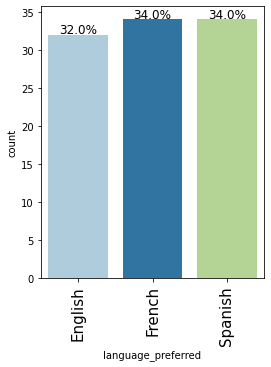

In [34]:
labeled_barplot(news, "language_preferred", perc=True)
plt.savefig('barplot_language.jpg',bbox_inches='tight')
#plt.show()

* Languages almost equal

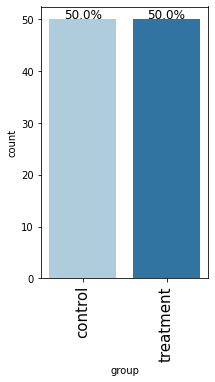

In [22]:
labeled_barplot(news, "group", perc=True)
plt.savefig('barplot_group.jpg',bbox_inches='tight')

* 50/50 for control and treatment will put us in Central Limit Theorem 

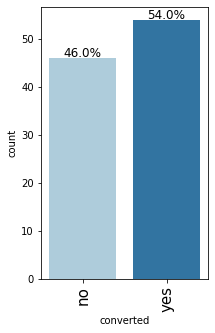

In [23]:
labeled_barplot(news, "converted", perc=True)
plt.savefig('barplot_converted.jpg',bbox_inches='tight')

* More converted to than didn't convert

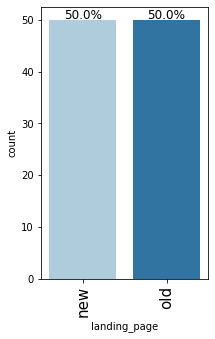

In [24]:
labeled_barplot(news, "landing_page", perc=True)
plt.savefig('barplot_landing_page.jpg',bbox_inches='tight')

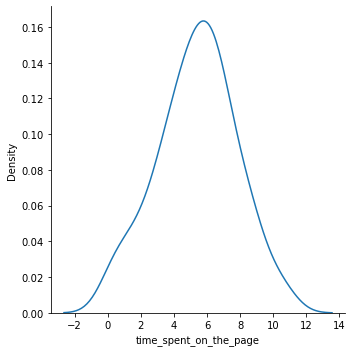

In [25]:
sns.displot(news['time_spent_on_the_page'], kind='kde')
#plt.show()
plt.savefig('kde_plot_timespent.jpg',bbox_inches='tight')

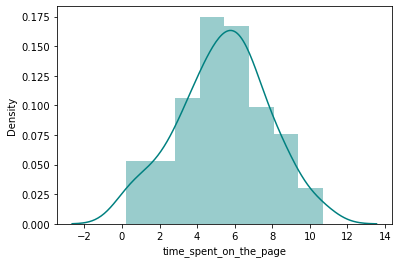

In [26]:
#Same analysis, different view
sns.distplot(news['time_spent_on_the_page'],color='teal')
#plt.show()
plt.savefig('dist_plot_timespent.jpg',bbox_inches='tight')

* Definitely normal distribution

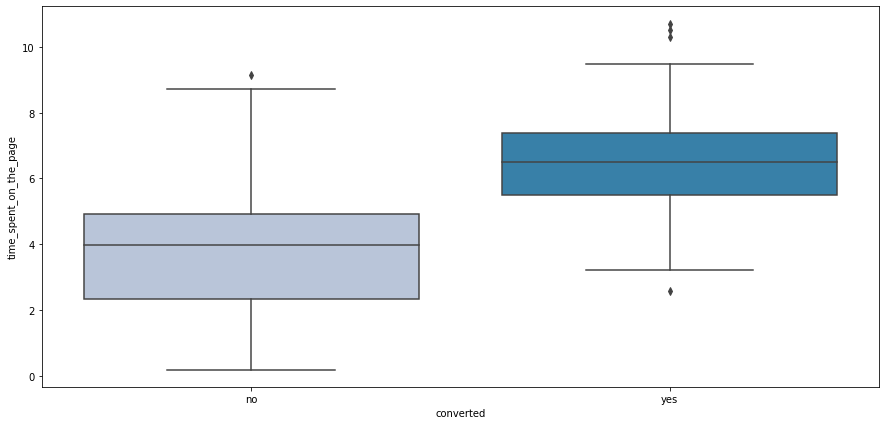

In [27]:
plt.figure(figsize=(15,7))
sns.boxplot(news["converted"],news["time_spent_on_the_page"],palette="PuBu")
#plt.show()
plt.savefig('box_converted.jpg',bbox_inches='tight')

* Looks like the people who didn't convert spent less time on the page compared to people who did convert

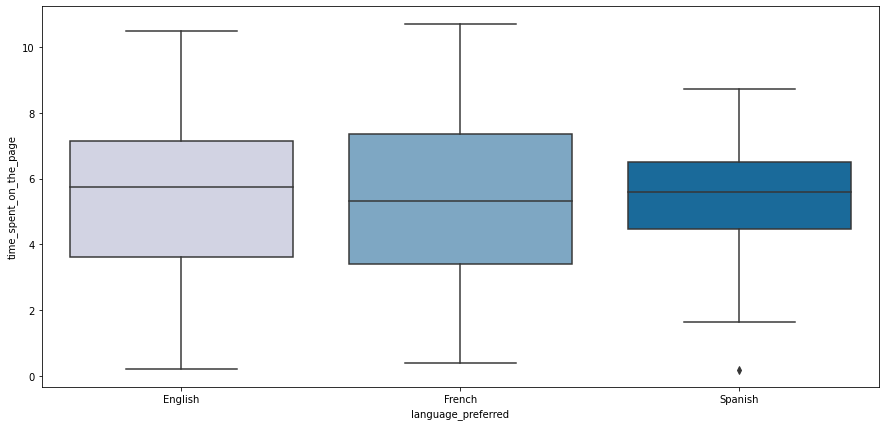

In [28]:
plt.figure(figsize=(15,7))
sns.boxplot(news["language_preferred"],news["time_spent_on_the_page"],palette="PuBu")
#plt.show()
plt.savefig('box_language.jpg',bbox_inches='tight')

* Language and time spent on the page seem to be in the same range with slightly less range in Spanish

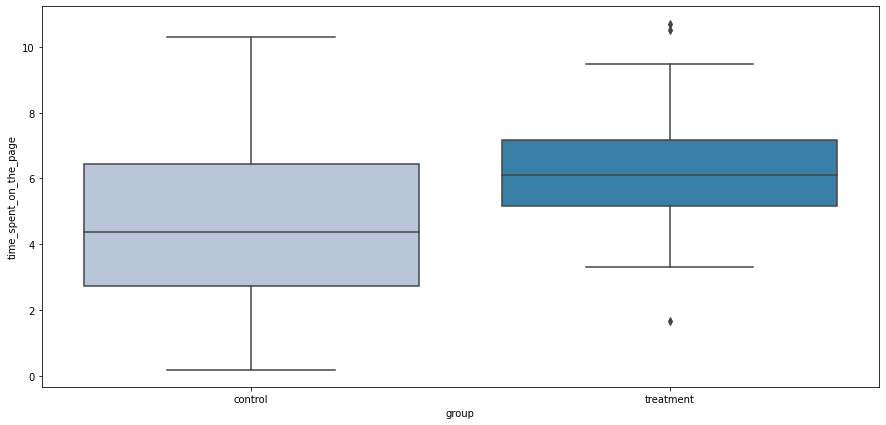

In [29]:
plt.figure(figsize=(15,7))
sns.boxplot(news["group"],news["time_spent_on_the_page"],palette="PuBu")
#plt.show()
plt.savefig('box_group.jpg',bbox_inches='tight')

* There is less time spent for the control compared to the treatment group
* The treatment group has a smaller range compared to the control group; so less variability and longer time spent

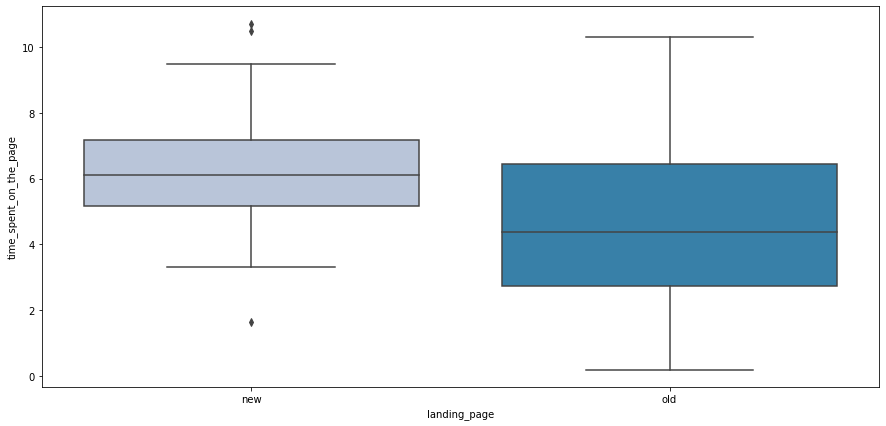

In [30]:
plt.figure(figsize=(15,7))
sns.boxplot(news["landing_page"],news["time_spent_on_the_page"],palette="PuBu")
#plt.show()
plt.savefig('box_landingpg.jpg',bbox_inches='tight')

* The new page has more time spent on it and a smaller range compared to the old landing page

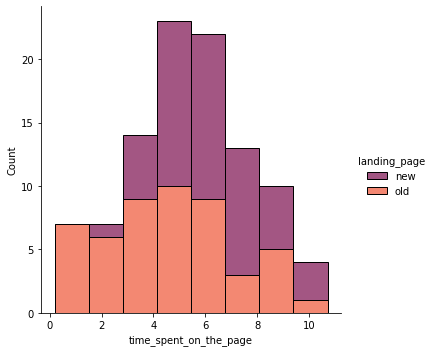

In [31]:
#Distribution plot
sns.displot(news,x='time_spent_on_the_page',hue='landing_page', palette='rocket',multiple='stack')
#plt.show()
plt.savefig('time_landing.jpg',bbox_inches='tight')

* Users seem to spend more time on the new page versus the old page

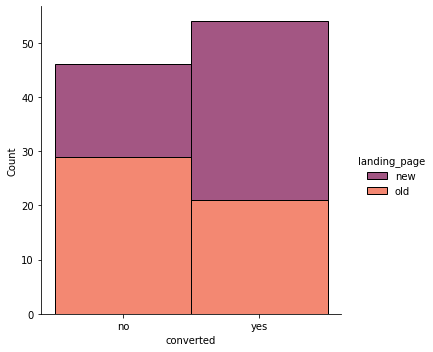

In [32]:
#Distribution plot
sns.displot(news,x='converted',hue='landing_page', palette='rocket',multiple='stack')
#plt.show()
plt.savefig('convert_landing.jpg',bbox_inches='tight')

* More converted on the new page
* More did not convert on the old page

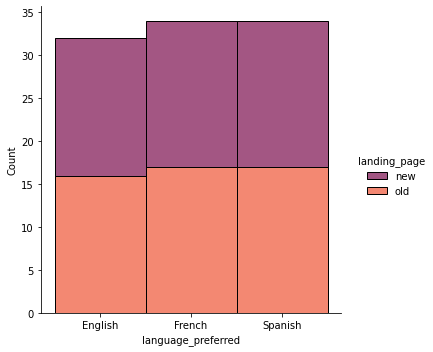

In [33]:
#Distribution plot
sns.displot(news,x='language_preferred',hue='landing_page', palette='rocket',multiple='stack')
#plt.show()
plt.savefig('language_landing.jpg',bbox_inches='tight')

* Language doesn't seem to be a factor but will verify further

In [45]:
news.groupby(by=['group','converted']).mean()

time_spent_on_the_page
group     converted                        
control   no                       3.349310
          yes                      6.166190
treatment no                       4.882353
          yes                      6.913939

* People who converted spent more time on the page 

In [83]:
news.groupby(by=['landing_page','converted']).count()

user_id  group  time_spent_on_the_page  \
landing_page converted                                           
new          no              17     17                      17   
             yes             33     33                      33   
old          no              29     29                      29   
             yes             21     21                      21   

                        language_preferred  
landing_page converted                      
new          no                         17  
             yes                        33  
old          no                         29  
             yes                        21

* In the old landing page 21/50 were converted and 29/50 were not converted
* In the new landing page 33/50 were converted and 17/50 were not converted
* The new landing page has a higher conversion rate versus the old landing page

In [49]:
pd.crosstab(news["language_preferred"],  # Make a crosstab
                     news["converted"])

converted,no,yes
language_preferred,,
English,11,21
French,19,15
Spanish,16,18


* Looks like more English were converted 
* French were less converted
* Spanish were slightly more converted than not

In [52]:
news.groupby(by=['language_preferred','landing_page']).mean()

time_spent_on_the_page
language_preferred landing_page                        
English            new                         6.663750
                   old                         4.454375
French             new                         6.196471
                   old                         4.310000
Spanish            new                         5.835294
                   old                         4.828235

* The mean time spent on the new page is about the same for each language user

### Levene’s test

We will test the null hypothesis

>$H_0$: All the population variances are equal

against the alternative hypothesis

>$H_a$: At least one variance is different from the rest

In [60]:
#Assumption 2: Homogeneity of Variance
# use levene function from scipy.stats library for this test

# find the p-value
statistic, p_value = stats.levene(news[news['language_preferred']=='English']['time_spent_on_the_page'],
                            news[news['language_preferred']=='French']['time_spent_on_the_page'],
                            news[news['language_preferred']=='Spanish']['time_spent_on_the_page'])
print('The p-value is', p_value)

The p-value is 0.06515086840327314


* Since the p-value is larger than the 5% significance level, we fail to reject the null hypothesis of homogeneity of variances.  The mean time spent on the new page same for the different language users

In [64]:
# separate the dataset by language and landing page new
English = news[(news['language_preferred']=='English') & (news['landing_page'] == 'new')]['time_spent_on_the_page']
Spanish = news[(news['language_preferred']=='Spanish') & (news['landing_page'] == 'new')]['time_spent_on_the_page']
French = news[(news['language_preferred']=='French') & (news['landing_page'] == 'new')]['time_spent_on_the_page']


In [65]:
test_stat, p_value = stats.f_oneway(English,Spanish,French)
print('The p-value is ', p_value)

The p-value is  0.43204138694325955


In [66]:
# print the conclusion based on p-value
if p_value < 0.05:
    print(f'As the p-value {p_value} is less than the level of significance, we reject the null hypothesis.')
else:
    print(f'As the p-value {p_value} is greater than the level of significance, we fail to reject the null hypothesis.')

As the p-value 0.43204138694325955 is greater than the level of significance, we fail to reject the null hypothesis.
